In [1]:
!pip install torch==2.1.0+cu121 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torchtext==0.16.0
!pip install nlpaug
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 680.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.0 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of torchvision to determine whic

In [2]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
imdb_df = pd.read_csv('IMDB Dataset.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Text Preprocessing

In [4]:
# Download stopwords from NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    # Join the list (if any) into string
    if isinstance(text, list):
        text = " ".join(text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    return " ".join(words)

# Synonym replacement and random deletion
synonym_aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
random_delete_aug = naw.RandomWordAug(action="delete", aug_p=0.3)

# Apply augmentations
def augment_text(text):
    augmented_texts = []
    augmented_texts.append(synonym_aug.augment(text))
    augmented_texts.append(random_delete_aug.augment(text))
    return augmented_texts

# Apply augmentation to the dataset
augmented_reviews = []
augmented_sentiments = []

for review, sentiment in zip(imdb_df['review'], imdb_df['sentiment']):
    augmented_reviews.extend(augment_text(review))
    augmented_sentiments.extend([sentiment] * 2)

# Create a new DataFrame for augmented data and merge it with the original dataset
augmented_df = pd.DataFrame({'review': augmented_reviews, 'sentiment': augmented_sentiments})
imdb_df_aug = pd.concat([imdb_df, augmented_df], ignore_index=True)

# Preprocess text for both original and augmented dataset
imdb_df['cleaned_review'] = imdb_df['review'].apply(preprocess_text)
imdb_df_aug['cleaned_review'] = imdb_df_aug['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


<ipython-input-15-1c469ae10bfa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=imdb_df, palette='viridis')


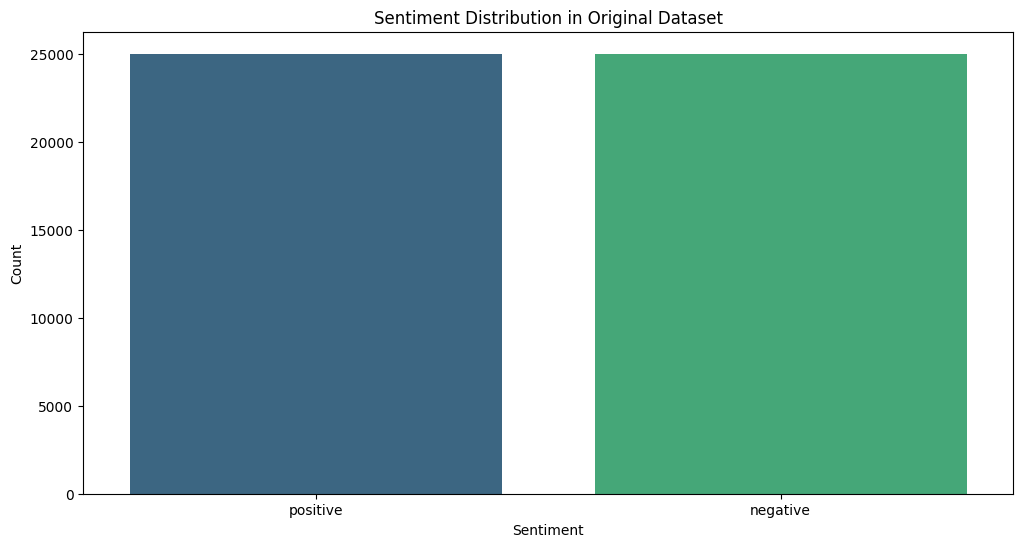

<ipython-input-15-1c469ae10bfa>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=imdb_df_aug, palette='viridis')


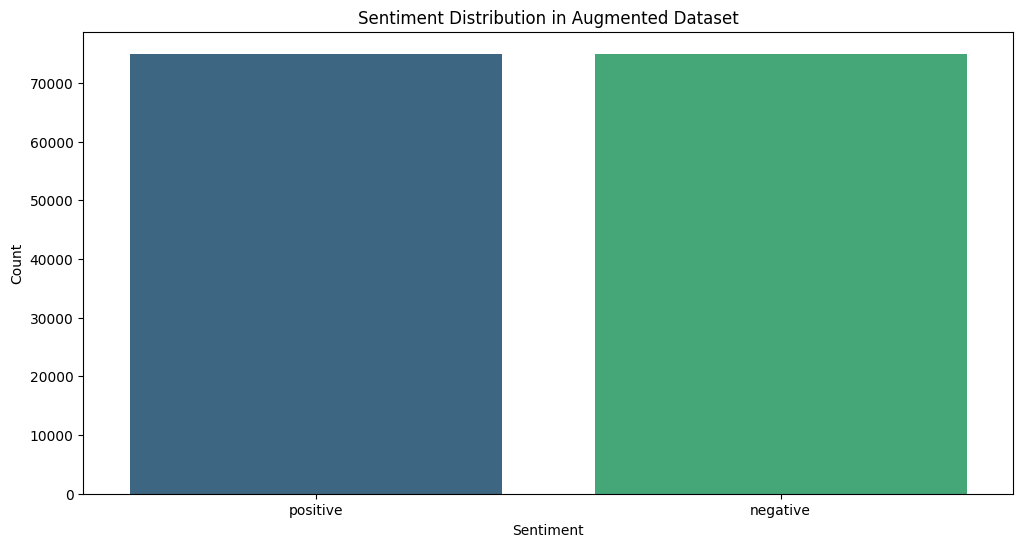

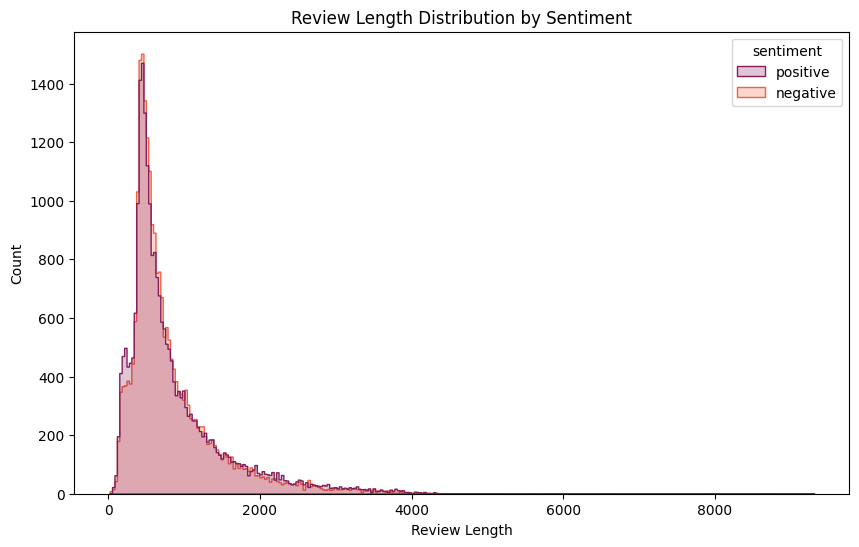

In [15]:
# Visualize word counts for each sentiment in the original and augmented dataset
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=imdb_df, palette='viridis')
plt.title('Sentiment Distribution in Original Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=imdb_df_aug, palette='viridis')
plt.title('Sentiment Distribution in Augmented Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


# Visualizing review lengths for each sentiment in the original dataset
imdb_df['review_length'] = imdb_df['cleaned_review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=imdb_df, x='review_length', hue='sentiment', palette='rocket', element='step')
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

Tokenization and Padding

Since PyTorch doesn't have a built-in tokenizer like Keras, we can use torchtext to tokenize and pad sequences.

In [5]:
from torchtext.vocab import build_vocab_from_iterator

# Tokenizer for splitting sentences into words
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for review in data_iter:
        yield tokenizer(review)

# Build vocabulary from tokenized reviews
vocab = build_vocab_from_iterator(yield_tokens(imdb_df['cleaned_review']), specials=['<unk>', '<pad>'])
vocab_aug = build_vocab_from_iterator(yield_tokens(imdb_df_aug['cleaned_review']), specials=['<unk>', '<pad>'])

# Set default index for unknown tokens
vocab.set_default_index(vocab['<unk>'])

# Convert reviews to sequences of integers
def encode_review(review):
    return [vocab[token] for token in tokenizer(review)]

encoded_reviews = [encode_review(review) for review in imdb_df['cleaned_review']]
encoded_reviews_aug = [encode_review(review) for review in imdb_df_aug['cleaned_review']]

# Padding Function to ensure all sequence are of same length
def pad_sequence(seq, max_len=100):
    if len(seq) < max_len:
        return seq + [vocab['<pad>']] * (max_len - len(seq))
    else:
        return seq[:max_len]

padded_reviews = [pad_sequence(seq) for seq in encoded_reviews]
padded_reviews_aug = [pad_sequence(seq) for seq in encoded_reviews_aug]



In [6]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1, dropout_prob=0.5):
        super(SentimentRNN, self).__init__()

        # Embedding layer to convert words to vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer for sequential data processing
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Batch normalization after LSTM output
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Fully connected layer for classification (binary output)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Sigmoid activation function for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)

        # Pass embeddings through LSTM layer
        lstm_out, _ = self.lstm(embedded)

        # Take the output of the last LSTM cell
        lstm_out_last_step = lstm_out[:, -1]

        # Apply batch normalization to LSTM output
        lstm_out_last_step = self.batch_norm(lstm_out_last_step)

        # Pass through fully connected layer and sigmoid activation
        out = self.fc(lstm_out_last_step)
        out = self.sigmoid(out)

        return out


In [7]:
def train_and_evaluate(imdb_df,padded_reviews,vocab):
    # Convert labels (0 for negative, 1 for positive)
    y = imdb_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(padded_reviews, y, test_size=0.2, random_state=42, stratify=y)

    x_train_tensor = torch.tensor(x_train)
    x_test_tensor = torch.tensor(x_test)
    y_train_tensor = torch.tensor(y_train)
    y_test_tensor = torch.tensor(y_test)

    train_data = TensorDataset(x_train_tensor, y_train_tensor)
    test_data = TensorDataset(x_test_tensor, y_test_tensor)

    batch_size = 32

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Instantiate model with vocabulary size
    vocab_size = len(vocab)
    model = SentimentRNN(vocab_size=vocab_size).to(device)
    print(model)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


    train_losses = []
    test_losses = []

    epochs = 5

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()  # Zero out gradients

            outputs = model(inputs).squeeze()  # Forward pass

            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation

            optimizer.step()  # Update weights

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}")

        model.eval()

        test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()

                outputs = model(inputs).squeeze()

                loss = criterion(outputs, labels)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Testing Loss: {avg_test_loss}")

    # Plotting the graph
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.show()

    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predictions = (outputs > 0.5).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F-1 Score: {f1:.2f}%\n\n")

Training model without augmented text
SentimentRNN(
  (embedding): Embedding(176806, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 1250/1250 [00:17<00:00, 72.23it/s]


Epoch 1/5, Training Loss: 0.6417798075199127
Epoch 1/5, Testing Loss: 0.45531754524182205


100%|██████████| 1250/1250 [00:14<00:00, 84.34it/s]


Epoch 2/5, Training Loss: 0.3501866013109684
Epoch 2/5, Testing Loss: 0.32315274882621275


100%|██████████| 1250/1250 [00:16<00:00, 75.16it/s]


Epoch 3/5, Training Loss: 0.23083455741107464
Epoch 3/5, Testing Loss: 0.3080671657436191


100%|██████████| 1250/1250 [00:14<00:00, 84.24it/s]


Epoch 4/5, Training Loss: 0.14860392562001942
Epoch 4/5, Testing Loss: 0.3562319681476861


100%|██████████| 1250/1250 [00:14<00:00, 84.80it/s]


Epoch 5/5, Training Loss: 0.09248246636688709
Epoch 5/5, Testing Loss: 0.42573211733668376


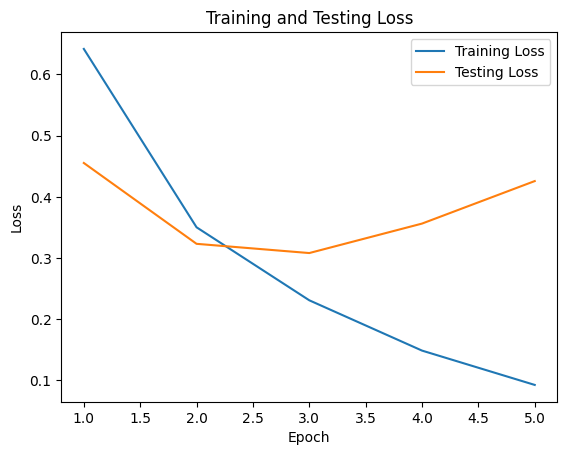


Test Accuracy: 0.86%
Precision: 0.87%
Recall: 0.85%
F-1 Score: 0.86%




In [16]:
# Dataset without augmented text
print("Training model without augmented text")
train_and_evaluate(imdb_df,padded_reviews,vocab)

Training model with augmented text
SentimentRNN(
  (embedding): Embedding(185057, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 3750/3750 [00:46<00:00, 81.18it/s]


Epoch 1/5, Training Loss: 0.44205988421738146
Epoch 1/5, Testing Loss: 0.2574842470144031


100%|██████████| 3750/3750 [00:46<00:00, 81.20it/s]


Epoch 2/5, Training Loss: 0.18535997983167568
Epoch 2/5, Testing Loss: 0.1564879600069861


100%|██████████| 3750/3750 [00:46<00:00, 80.42it/s]


Epoch 3/5, Training Loss: 0.11471984179516634
Epoch 3/5, Testing Loss: 0.12542265629681792


100%|██████████| 3750/3750 [00:46<00:00, 80.36it/s]


Epoch 4/5, Training Loss: 0.08069528628854702
Epoch 4/5, Testing Loss: 0.10795231764194871


100%|██████████| 3750/3750 [00:46<00:00, 81.35it/s]


Epoch 5/5, Training Loss: 0.0631588708560293
Epoch 5/5, Testing Loss: 0.10635965617213732


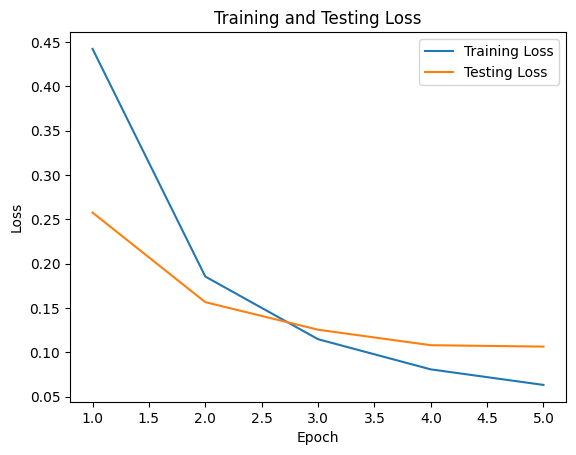


Test Accuracy: 0.97%
Precision: 0.97%
Recall: 0.96%
F-1 Score: 0.97%




In [17]:
# Dataset with augmented text
print("Training model with augmented text")
train_and_evaluate(imdb_df_aug,padded_reviews_aug,vocab_aug)